## Web Scraping Project





### ที่มาเเละความสำคัญ

ปัจจุบันตลาดหนังสือมีการแข่งขันสูง และร้านหนังสือออนไลน์ต้องการกลยุทธ์ในการเลือกหนังสือที่ตรงกับความนิยมและความต้องการของลูกค้า การนำข้อมูลมาวิเคราะห์จะช่วยในการตัดสินใจเลือกหนังสือที่มีโอกาสขายได้มากขึ้น ทำให้ร้านค้าสามารถแข่งขันได้อย่างมีประสิทธิภาพมากขึ้น

การวิเคราะห์ข้อมูลหนังสือ เช่น รีวิว ราคาตลาด และการเคลื่อนไหวของสินค้าคงคลัง เป็นเครื่องมือที่สำคัญในการทำให้ร้านหนังสือสามารถวางแผนการลงทุนและจัดการสต็อกหนังสือได้อย่างแม่นยำ เพราะฉะนั้นการใช้ข้อมูลเหล่านี้จะช่วยเพิ่มโอกาสในการสร้างกำไรและตอบสนองต่อความต้องการของลูกค้าได้ดียิ่งขึ้น

### วัตถุประสงค์

1. เพื่อช่วยร้านขายหนังสือออนไลน์ในการตัดสินใจเลือกหนังสือเข้ามาจำหน่ายได้อย่างมีประสิทธิภาพ 
2. เพื่อเพิ่มผลตอบแทนจากการลงทุนให้มากที่สุด 

## ขั้นตอนที่ 1 การดึงข้อมูลจากเว็บ (Web Scraping)

In [38]:
# Import necessary libraries
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
import pandas as pd
from urllib.parse import urljoin
import seaborn as sns
import matplotlib.pyplot as plt

##### เก็บ URL หนังสือ ลงในลิสต์ book_links

In [4]:
from urllib.request import urlopen as uReq
from urllib.parse import urljoin
from bs4 import BeautifulSoup as soup
import pandas as pd

# Book category URLs
categories = {
    "Books": "https://books.toscrape.com/catalogue/category/books_1/index.html"
}
book_links = []  # Store all book links

# Loop through the categories
for category_name, base_url in categories.items():
    try:
        # Load the first page to find the total number of pages
        uClient = uReq(base_url)
        page_html = uClient.read()
        uClient.close()

        # Parse HTML using BeautifulSoup
        page_soup = soup(page_html, "html.parser")

        # Find the total number of pages
        pagination = page_soup.find("li", class_="current")
        if pagination:
            total_pages = int(pagination.text.strip().split()[-1])  # Extract the last page number
        else:
            total_pages = 1  # If no pagination exists, there's only one page

        print(f"Category '{category_name}' has {total_pages} pages.")

        # Loop through each page
        for page_number in range(1, total_pages + 1):
            myurl = f"{base_url[:-10]}page-{page_number}.html" if page_number > 1 else base_url
            
            try:
                uClient = uReq(myurl)
                page_html = uClient.read()
                uClient.close()
            except Exception as e:
                print(f"Error fetching page {page_number} of category {category_name}: {e}")
                break
            
            page_soup = soup(page_html, "html.parser")
            bookshelf = page_soup.findAll("li", class_="col-xs-6 col-sm-4 col-md-3 col-lg-3")

            if not bookshelf:
                break

            # Extract book links
            for book in bookshelf:
                book_link = urljoin(base_url, book.h3.a['href'])
                book_links.append(book_link)
                print(f"Link to the book: {book_link}")

    except Exception as e:
        print(f"Failed to process category '{category_name}': {e}")

# Save book links to CSV
book_links_df = pd.DataFrame(book_links, columns=["Book Link"])
book_links_df.to_csv("Book_Links.csv", index=False, encoding="utf-8")

print("Book links have been written to Book_Links.csv")


Category 'Books' has 50 pages.
Link to the book: https://books.toscrape.com/catalogue/a-light-in-the-attic_1000/index.html
Link to the book: https://books.toscrape.com/catalogue/tipping-the-velvet_999/index.html
Link to the book: https://books.toscrape.com/catalogue/soumission_998/index.html
Link to the book: https://books.toscrape.com/catalogue/sharp-objects_997/index.html
Link to the book: https://books.toscrape.com/catalogue/sapiens-a-brief-history-of-humankind_996/index.html
Link to the book: https://books.toscrape.com/catalogue/the-requiem-red_995/index.html
Link to the book: https://books.toscrape.com/catalogue/the-dirty-little-secrets-of-getting-your-dream-job_994/index.html
Link to the book: https://books.toscrape.com/catalogue/the-coming-woman-a-novel-based-on-the-life-of-the-infamous-feminist-victoria-woodhull_993/index.html
Link to the book: https://books.toscrape.com/catalogue/the-boys-in-the-boat-nine-americans-and-their-epic-quest-for-gold-at-the-1936-berlin-olympics_992/

##### Scrape รายละเอียดของหนังสือจาก URL รวมถึงหมวดหมู่, ชื่อหนังสือ, ราคา, เรตติ้ง, จำนวน Availability และ Number of reviews

In [5]:
# ฟังก์ชันเพื่อดึงรายละเอียดของหนังสือจาก URL รวมถึงหมวดหมู่, ชื่อหนังสือ, ราคา, เรตติ้ง, จำนวน Availability และ Number of reviews
def get_book_details(book_page_url):
    try:
        response = uReq(book_page_url)
        page_html = response.read()
        response.close()
    except Exception as e:
        print(f"เกิดข้อผิดพลาดในการดึงข้อมูล {book_page_url}: {e}")
        return None, None, None, None, None, None  # หากเกิดข้อผิดพลาด ให้คืนค่า None
    
    # ใช้ BeautifulSoup เพื่อแปลง HTML
    page_soup = soup(page_html, "html.parser")
    
    # ดึงหมวดหมู่จาก breadcrumb
    breadcrumb = page_soup.find("ul", {"class": "breadcrumb"})
    category = None
    if breadcrumb:
        items = breadcrumb.find_all("li")
        if len(items) >= 3:
            category = items[2].get_text(strip=True)  # ดึงหมวดหมู่จาก <li> ที่สาม

    # ดึงชื่อหนังสือ
    book_title = page_soup.find("h1").get_text(strip=True)
    
    # ดึงราคา
    book_price = page_soup.find("p", {"class": "price_color"}).get_text(strip=True)
    
    # ดึงเรตติ้ง
    star_rating_class = page_soup.find("p", {"class": "star-rating"})["class"][1]  # ค่าคะแนนเรตติ้งอยู่ที่ index 1 ของ class
    rating_mapping = {"One": 1, "Two": 2, "Three": 3, "Four": 4, "Five": 5}
    book_rating = rating_mapping.get(star_rating_class, 0)  # ใช้ 0 ถ้าไม่พบค่าที่ตรงกัน

    # ดึง Availability จากตาราง (จำนวนหนังสือที่มีในสต็อก)
    availability_info = page_soup.find("table", {"class": "table table-striped"})
    availability_text = availability_info.find_all("tr")[5].find("td").get_text(strip=True)
    availability_number = ''.join(filter(str.isdigit, availability_text))  # ดึงเฉพาะตัวเลข

    # ดึงจำนวนรีวิว
    reviews_text = availability_info.find_all("tr")[6].find("td").get_text(strip=True)
    number_of_reviews = ''.join(filter(str.isdigit, reviews_text))  # ดึงเฉพาะตัวเลข

    return category, book_title, book_price, book_rating, availability_number, number_of_reviews

# อ่านลิงก์หนังสือจากไฟล์ CSV
book_links_df = pd.read_csv("Book_Links.csv")
book_links = book_links_df["Book Link"].tolist()

# รายการเพื่อเก็บข้อมูลหนังสือ
books_data = []

# วนลูปผ่านลิงก์หนังสือแต่ละเล่ม
for book_link in book_links:
    # ดึงรายละเอียดของหนังสือ
    category, title, price, rating, availability, reviews = get_book_details(book_link)
    
    if title and price and rating is not None:
        # เพิ่มข้อมูลลงในรายการ
        books_data.append({
            "Category": category,
            "Title": title, 
            "Price": price, 
            "Rating": rating, 
            "Availability": availability, 
            "Number of Reviews": reviews
        })

##### สร้าง DataFrame และเขียนข้อมูลลงในไฟล์ CSV

In [6]:
# สร้าง DataFrame และเขียนข้อมูลลงในไฟล์ CSV
books_df = pd.DataFrame(books_data)
books_df.to_csv("Books_Details_with_Category.csv", index=False, encoding="utf-8")

print("ข้อมูลหนังสือได้ถูกเขียนลงในไฟล์ Books_Details_with_Category.csv")

ข้อมูลหนังสือได้ถูกเขียนลงในไฟล์ Books_Details_with_Category.csv


## ขั้นตอนที่ 2 การทำความสะอาดและเตรียมข้อมูล (Data Cleaning and Preparation)

### 2.1 การลบค่าที่เป็นค่าว่าง (Missing Values)

In [25]:

df = pd.read_csv("C:/Users/Dell/Web-Scraping-Project/Books_Details_with_Category.csv")

print(df.isnull().sum())
df = df.dropna()


Category             0
Title                0
Price                0
Rating               0
Availability         0
Number of Reviews    0
dtype: int64


### 2.2การลบข้อมูลซ้ำ (Duplicate Data)

In [26]:
# ลบข้อมูลที่ซ้ำในคอลัมน์ Title โดยเก็บเฉพาะแถวแรกที่เจอ
df = df.drop_duplicates(subset='Title', keep='first')


### 2.3 ตรวจสอบประเภท Datatype ในแต่ละ column

2.3.1 แสดง Datatype ในแต่ละ column

In [27]:
print(df.dtypes)

Category             object
Title                object
Price                object
Rating                int64
Availability          int64
Number of Reviews     int64
dtype: object


In [28]:
df["Price"] = df["Price"].str.replace("£", "").astype(float)

In [29]:
print(df)

               Category                                              Title  \
0                Poetry                               A Light in the Attic   
1    Historical Fiction                                 Tipping the Velvet   
2               Fiction                                         Soumission   
3               Mystery                                      Sharp Objects   
4               History              Sapiens: A Brief History of Humankind   
..                  ...                                                ...   
995            Classics  Alice in Wonderland (Alice's Adventures in Won...   
996      Sequential Art   Ajin: Demi-Human, Volume 1 (Ajin: Demi-Human #1)   
997  Historical Fiction  A Spy's Devotion (The Regency Spies of London #1)   
998             Mystery                1st to Die (Women's Murder Club #1)   
999              Travel                 1,000 Places to See Before You Die   

     Price  Rating  Availability  Number of Reviews  
0    51.7

### 2.4 ส่งออกไฟล์ที่ทำความสะอาดข้อมูลแล้ว

In [30]:
df.to_csv('Cleaning_data.csv', index=False, encoding='utf-8')

###  Basic Data Profiling

In [31]:
data = pd.read_csv('Cleaning_data.csv', encoding='unicode_escape')

In [32]:
data.shape

(999, 6)

In [33]:
data.head()

,Category,Title,Price,Rating,Availability,Number of Reviews
0,Poetry,A Light in the Attic,51.77,3,22,0
1,Historical Fiction,Tipping the Velvet,53.74,1,20,0
2,Fiction,Soumission,50.10,1,20,0
3,Mystery,Sharp Objects,47.82,4,20,0
4,History,Sapiens: A Brief History of Humankind,54.23,5,20,0


In [34]:
data.tail()

,Category,Title,Price,Rating,Availability,Number of Reviews
994,Classics,Alice in Wonderland (Alice's Adventures in Won...,55.53,1,1,0
995,Sequential Art,"Ajin: Demi-Human, Volume 1 (Ajin: Demi-Human #1)",57.06,4,1,0
996,Historical Fiction,A Spy's Devotion (The Regency Spies of London #1),16.97,5,1,0
997,Mystery,1st to Die (Women's Murder Club #1),53.98,1,1,0
998,Travel,"1,000 Places to See Before You Die",26.08,5,1,0


## ขั้นตอนที่ 3 การวิเคราะห์ข้อมูล (Data Analysis)

#### การวิเคราะห์ข้อมูลหนังสือ ได้แก่ หมวดหมู่, ชื่อหนังสือ, ราคา, เรตติ้ง, จำนวน Availability และ Number of reviews เพื่อตอบคำถามทางธุรกิจ 

##### 1.ประเภทหนังสือใดได้รับ Rating จากลูกค้าสูงสุด และมี Rating เฉลี่ยต่อเล่มเท่าใด?

              Category  avg_rating
15             Erotica    5.000000
2        Adult Fiction    5.000000
29              Novels    5.000000
9    Christian Fiction    4.166667
19              Health    3.750000
3                  Art    3.625000
33              Poetry    3.526316
24               Humor    3.400000
43        Spirituality    3.333333
49         Young Adult    3.296296
21  Historical Fiction    3.230769
17             Fiction    3.184615
27           New Adult    3.166667
25               Music    3.153846
36            Religion    3.142857
48      Womens Fiction    3.117647
16             Fantasy    3.042553
20          Historical    3.000000
4        Autobiography    3.000000
44    Sports and Games    3.000000
45            Suspense    3.000000
41      Sequential Art    2.973333
22             History    2.944444
26             Mystery    2.937500
38             Science    2.928571
6             Business    2.916667
18      Food and Drink    2.900000
28          Nonficti

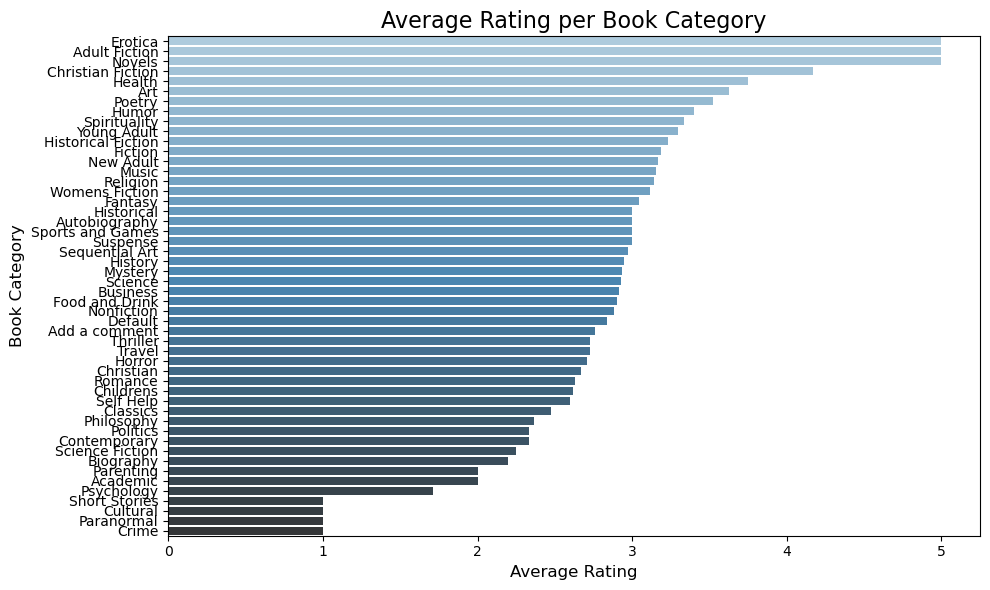

In [48]:
# ใช้ groupby เพื่อรวมข้อมูลตามประเภทหนังสือ (Category) และคำนวณค่าเฉลี่ยของเรตติ้ง
rating_analysis = cleaned_data_df.groupby("Category").agg(
    avg_rating=("Rating", "mean"),  # ค่าเฉลี่ยของเรตติ้ง
    max_rating=("Rating", "max"),   # เรตติ้งสูงสุด
    num_books=("Title", "count")    # จำนวนหนังสือในหมวดหมู่
).reset_index()

# จัดเรียงข้อมูลตามค่าเรตติ้งเฉลี่ยจากมากไปน้อย
rating_analysis = rating_analysis.sort_values(by="avg_rating", ascending=False)

# เลือกเฉพาะคอลัมน์ avg_rating และ Category
rating_analysis = rating_analysis[["Category", "avg_rating"]]

# แสดงตารางข้อมูล
print(rating_analysis)

# สร้างกราฟแท่งแสดงค่าเฉลี่ยเรตติ้งต่อหมวดหมู่
plt.figure(figsize=(10, 6))
sns.barplot(x="avg_rating", y="Category", data=rating_analysis, palette="Blues_d")

# เพิ่มชื่อกราฟและแกน
plt.title('Average Rating per Book Category', fontsize=16)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Book Category', fontsize=12)

# แสดงกราฟ
plt.tight_layout()
plt.show()


##### 2. แนวโน้มราคาเฉลี่ยของหนังสือในแต่ละประเภท ?

Index(['Category', 'Title', 'Price', 'Rating', 'Availability',
       'Number of Reviews'],
      dtype='object')
              Category      Price
0             Suspense  58.330000
1               Novels  54.810000
2             Politics  53.613333
3               Health  51.452500
4            New Adult  46.383333
5            Christian  42.496667
6     Sports and Games  41.166000
7            Self Help  40.620000
8               Travel  39.794545
9              Fantasy  39.749149
10                 Art  38.520000
11           Parenting  37.350000
12             History  37.295000
13       Autobiography  37.053333
14      Womens Fiction  36.791176
15            Cultural  36.580000
16            Classics  36.545263
17        Contemporary  36.200000
18             Fiction  36.066615
19              Poetry  35.974211
20              Horror  35.949412
21       Short Stories  35.880000
22       Add a comment  35.796418
23               Music  35.636923
24         Young Adult  35.449074
25

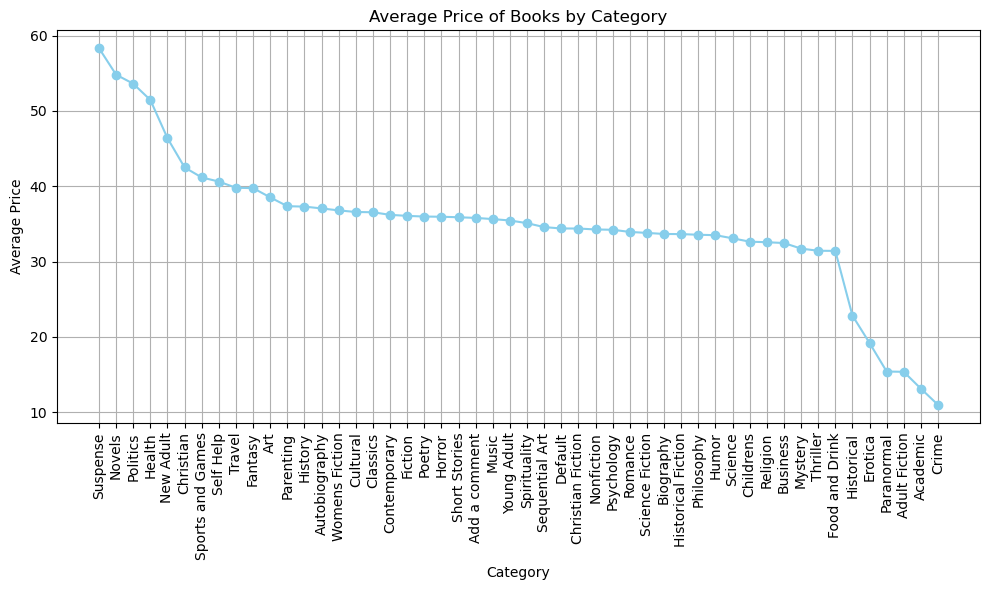

In [49]:
# ตรวจสอบชื่อคอลัมน์
print(data.columns)

# คำนวณราคาเฉลี่ยของหนังสือตามแต่ละประเภท
average_price_by_category = data.groupby('Category')['Price'].mean().reset_index()

# เรียงข้อมูลตามราคาเฉลี่ยจากมากไปน้อย
average_price_by_category = average_price_by_category.sort_values(by='Price', ascending=False).reset_index(drop=True)

# แสดงผลลัพธ์
print(average_price_by_category)

# สร้างกราฟแนวโน้มราคาเฉลี่ยของหนังสือตามแต่ละประเภท (line graph)
plt.figure(figsize=(10, 6))
plt.plot(average_price_by_category['Category'], average_price_by_category['Price'], marker='o', linestyle='-', color='skyblue')

# ปรับแต่งกราฟ
plt.xticks(rotation=90)  # หมุนชื่อประเภทหนังสือ 90 องศาเพื่อให้เห็นชัดขึ้น
plt.xlabel('Category')
plt.ylabel('Average Price')
plt.title('Average Price of Books by Category')
plt.grid(True)

# แสดงกราฟ
plt.tight_layout()
plt.show()


##### 3.มีความสัมพันธ์ระหว่าง Rating และ จำนวน Availability หรือไม่?

Rating          0
Availability    0
dtype: int64
                Rating  Availability
Rating        1.000000      0.015309
Availability  0.015309      1.000000


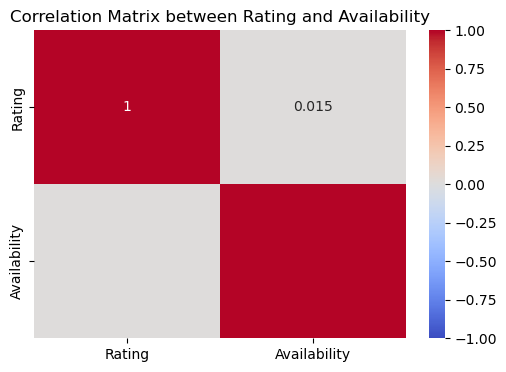

In [50]:
# ตรวจสอบว่ามีค่า NaN หรือไม่
print(data[['Rating', 'Availability']].isnull().sum())

# ถ้ามี NaN ให้พิจารณาลบหรือจัดการ
data = data.dropna(subset=['Rating', 'Availability'])

# คำนวณค่าสหสัมพันธ์
correlation_matrix = data[['Rating', 'Availability']].corr()

# แสดงผลลัพธ์
print(correlation_matrix)

# สร้างตาราง matrix
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix between Rating and Availability')
plt.show()



##### 4 สินค้าคงคลังเฉลี่ยของหนังสือแต่ละประเภท ?

              Category  Average Availability
30          Paranormal              1.000000
44    Sports and Games              2.000000
10            Classics              2.894737
2        Adult Fiction              3.000000
31           Parenting              3.000000
0             Academic              5.000000
48      Womens Fiction              5.352941
4        Autobiography              6.333333
35          Psychology              7.428571
32          Philosophy              7.454545
21  Historical Fiction              7.461538
38             Science              7.500000
16             Fantasy              7.659574
37             Romance              7.685714
1        Add a comment              7.701493
39     Science Fiction              7.812500
7            Childrens              7.896552
42       Short Stories              8.000000
23              Horror              8.000000
45            Suspense              8.000000
47              Travel              8.090909
27        

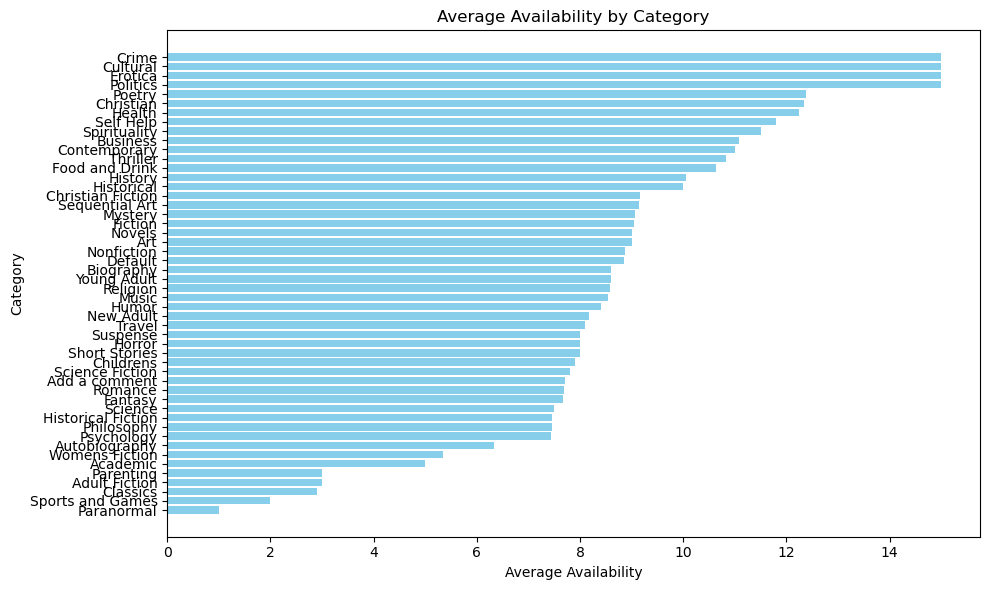

In [52]:
cleaned_data_df = pd.read_csv('Cleaning_data.csv')

# แปลง Availability เป็นตัวเลข ถ้า Availability มีค่าที่ไม่ใช่ตัวเลขให้แปลงเป็น NaN
cleaned_data_df['Availability'] = pd.to_numeric(cleaned_data_df['Availability'], errors='coerce')

# สร้างตารางที่แสดงค่าเฉลี่ยของ Availability ในแต่ละหมวดหมู่
average_availability_by_category_df = cleaned_data_df.groupby('Category')['Availability'].mean().reset_index()

# เปลี่ยนชื่อคอลัมน์สำหรับการแสดงผลที่เข้าใจง่ายขึ้น
average_availability_by_category_df.columns = ['Category', 'Average Availability']

# เรียงข้อมูลจากน้อยไปมาก
average_availability_by_category_df = average_availability_by_category_df.sort_values(by='Average Availability')

# แสดงตารางหลังจากเรียงข้อมูล
print(average_availability_by_category_df)

# สร้างกราฟแท่งแนวนอน (Horizontal Bar Plot)
plt.figure(figsize=(10, 6))
plt.barh(average_availability_by_category_df['Category'], average_availability_by_category_df['Average Availability'], color='skyblue')
plt.xlabel('Average Availability')
plt.ylabel('Category')
plt.title('Average Availability by Category')
plt.tight_layout()

# แสดงกราฟ
plt.show()


##### 5. Rating เฉลี่ยแต่ละประเภท และ ราคาเฉลี่ยแต่ละประเภท มีความสัมพันธ์ต่อจำนวนสินค้าคงคลังในแต่ละประเภท หรือไม่? 

              Category    Rating      Price  Availability
0             Academic  2.000000  13.120000             5
1        Add a comment  2.761194  35.796418           516
2        Adult Fiction  5.000000  15.360000             3
3                  Art  3.625000  38.520000            72
4        Autobiography  3.000000  37.053333            57
5            Biography  2.200000  33.662000            43
6             Business  2.916667  32.460000           133
7            Childrens  2.620690  32.638276           229
8            Christian  2.666667  42.496667            37
9    Christian Fiction  4.166667  34.385000            55
10            Classics  2.473684  36.545263            55
11        Contemporary  2.333333  36.200000            33
12               Crime  1.000000  10.970000            15
13            Cultural  1.000000  36.580000            15
14             Default  2.835526  34.392697          1345
15             Erotica  5.000000  19.190000            15
16            

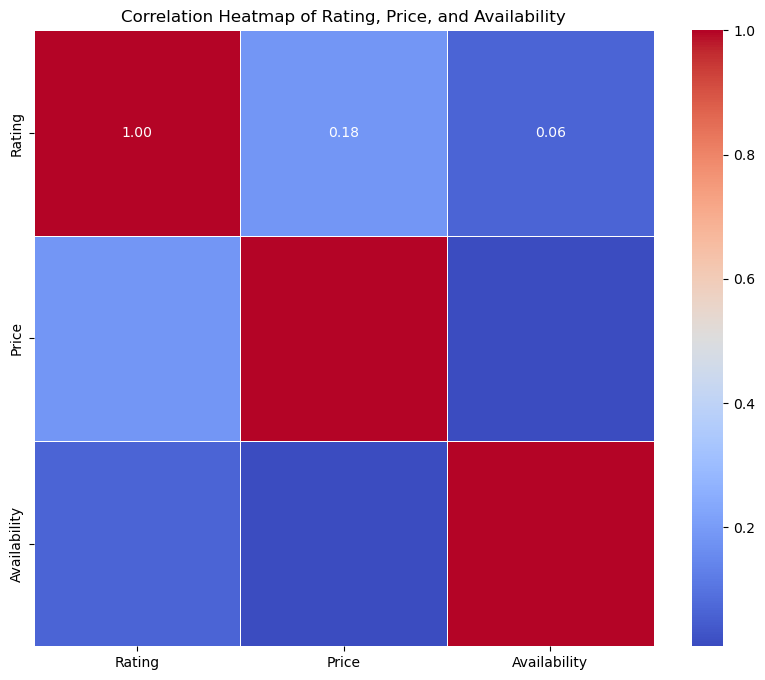

In [53]:
# คำนวณค่าเฉลี่ยของ Rating และ Price รวมถึงยอดรวมของ Availability ต่อ Category
grouped_data = data.groupby('Category').agg({
    'Rating': 'mean',          # ค่าเฉลี่ยของ Rating
    'Price': 'mean',           # ค่าเฉลี่ยของ Price
    'Availability': 'sum'      # รวมยอดสินค้าคงคลัง
}).reset_index()

print(grouped_data)

# สร้างตารางดมตริกสำหรับ Rating, Price และ Availability
corr_matrix = grouped_data[['Rating', 'Price', 'Availability']].corr()

# สร้าง heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Rating, Price, and Availability')
plt.show()


##### 6.หนังสือเล่มใดในแต่ละประเภทที่มีการจัดอันดับสูงสุดจากลูกค้า?

In [54]:
# แปลง Rating เป็นตัวเลข ถ้า Rating มีค่าที่ไม่ใช่ตัวเลขให้แปลงเป็น NaN
cleaned_data_df['Rating'] = pd.to_numeric(cleaned_data_df['Rating'], errors='coerce')

# หาหนังสือที่มีเรตติ้งสูงสุดในแต่ละหมวดหมู่
highest_rated_books_df = cleaned_data_df.loc[cleaned_data_df.groupby('Category')['Rating'].idxmax()]

# เลือกเฉพาะคอลัมน์ที่ต้องการแสดง
highest_rated_books_df = highest_rated_books_df[['Category', 'Title', 'Rating']]

# แสดงตาราง
print(highest_rated_books_df)

               Category                                              Title  \
615            Academic                Logan Kade (Fallen Crest High #5.5)   
180       Add a comment                                     Modern Romance   
843       Adult Fiction               Fifty Shades Freed (Fifty Shades #3)   
905                 Art                                     Ways of Seeing   
636       Autobiography     Approval Junkie: Adventures in Caring Too Much   
539           Biography                Benjamin Franklin: An American Life   
138            Business  The Third Wave: An Entrepreneur’s Vision of th...   
223           Childrens                  Walt Disney's Alice in Wonderland   
127           Christian  (Un)Qualified: How God Uses Broken People to D...   
174   Christian Fiction                                     Redeeming Love   
586            Classics                                  The Secret Garden   
265        Contemporary                Someone Like You (The Har

## ขั้นตอนที่ 4 การสร้างภาพแสดงข้อมูล (Visualization)

C:\Users\Dell\AppData\Local\Temp\ipykernel_20796\3489143058.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(closest_books))  # ใช้ colormap ที่มีสีหลากหลาย


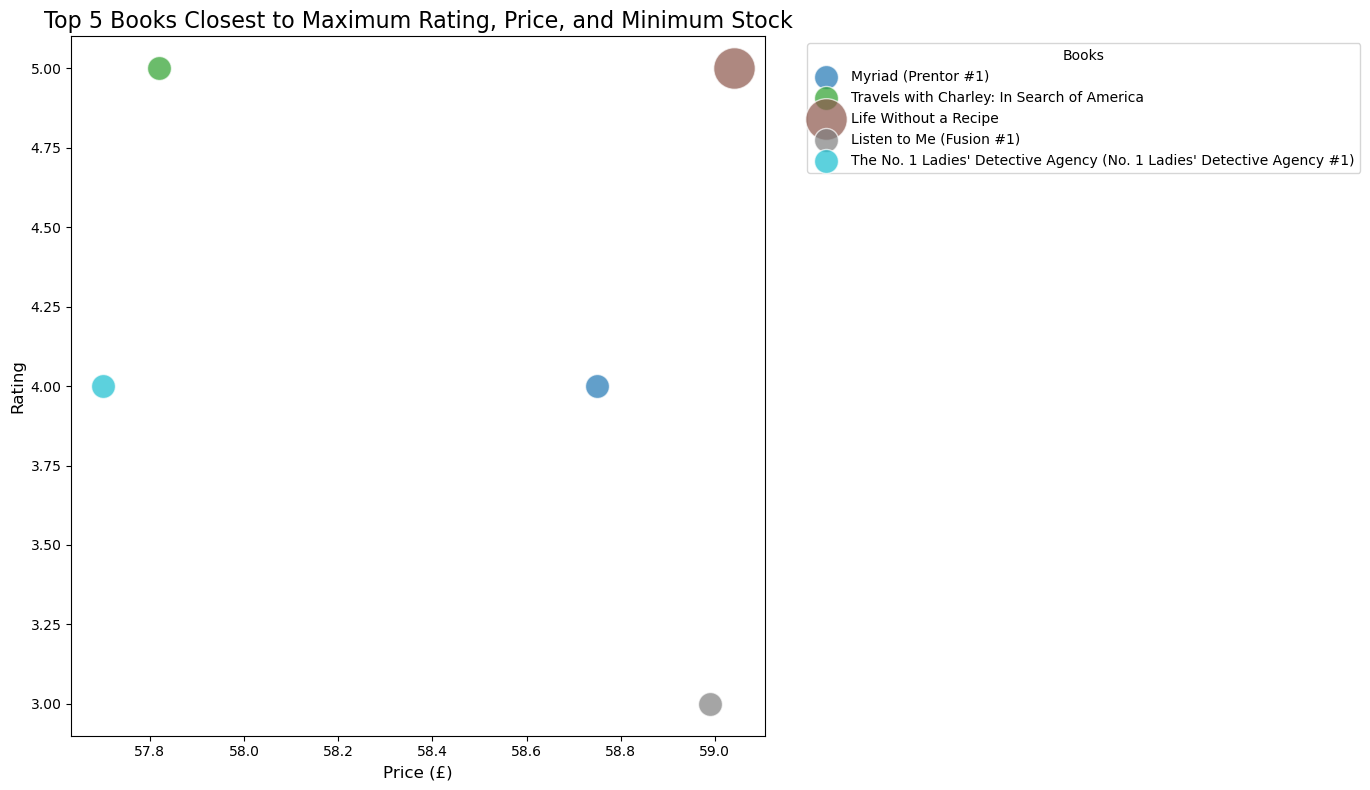

In [55]:

# อ่านข้อมูลจากไฟล์ CSV
cleaned_data_df = pd.read_csv('Cleaning_data.csv')

# แปลงข้อมูลเป็นตัวเลข
cleaned_data_df['Price'] = cleaned_data_df['Price'].astype(str).str.replace('£', '', regex=False)
cleaned_data_df['Price'] = pd.to_numeric(cleaned_data_df['Price'], errors='coerce')
cleaned_data_df['Rating'] = pd.to_numeric(cleaned_data_df['Rating'], errors='coerce')
cleaned_data_df['Availability'] = pd.to_numeric(cleaned_data_df['Availability'], errors='coerce')

# ค่าที่ต้องการเปรียบเทียบ
max_rating = cleaned_data_df['Rating'].max()
max_price = cleaned_data_df['Price'].max()
min_stock = cleaned_data_df['Availability'].min()

# คำนวณระยะทางที่เป็น Euclidean Distance เพื่อตรวจหาหนังสือที่ใกล้เคียงที่สุด
cleaned_data_df['distance'] = ((cleaned_data_df['Rating'] - max_rating) ** 2 +
                                (cleaned_data_df['Price'] - max_price) ** 2 +
                                (cleaned_data_df['Availability'] - min_stock) ** 2) ** 0.5

# หาหนังสือที่ใกล้เคียงกับเงื่อนไขทั้งสาม
closest_books = cleaned_data_df.sort_values(by='distance').head(5)

# สร้างกราฟ Bubble Chart
plt.figure(figsize=(14, 8))

# สร้าง color map สำหรับการแสดงชื่อหนังสือ
colors = plt.cm.get_cmap('tab10', len(closest_books))  # ใช้ colormap ที่มีสีหลากหลาย

for i, (index, row) in enumerate(closest_books.iterrows()):
    plt.scatter(
        x=row['Price'],
        y=row['Rating'],
        s=row['Availability'] * 300,  # ขนาดของลูกโป่งแสดงจำนวนสต๊อก
        alpha=0.7,
        color=colors(i),  # ใช้สีจาก colormap
        edgecolors='w',
        label=row['Title']  # ใช้ชื่อหนังสือเป็น label
    )


plt.title('Top 5 Books Closest to Maximum Rating, Price, and Minimum Stock', fontsize=16)
plt.xlabel('Price (£)', fontsize=12)
plt.ylabel('Rating', fontsize=12)

# แสดง legend
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), title='Books')

plt.tight_layout()
plt.show()

##### จากตารางความสัมพันธ์ระหว่าง Rating , Price และ availability  มีค่าความสัมพันธ์น้อย จากตารางในข้อ 3.3 ดังนั้นร้านควรพิจารณาสั่งซื้อหนังสือ ที่มีราคาสูง , rating สูง และ availability ต่ำ ในการจำหน่าย โดย หนังสือ 5 อันดับแรกที่ตรงเงื่อนไข ได้แก่  Myriad (Prentor #1) , Travels with Charley: In Search of America, Life Without a Recipe, Listen to Me (Fusion #1), The No. 1 Ladies' Detective Agency (No. 1 Ladies' Detective Agency #1)

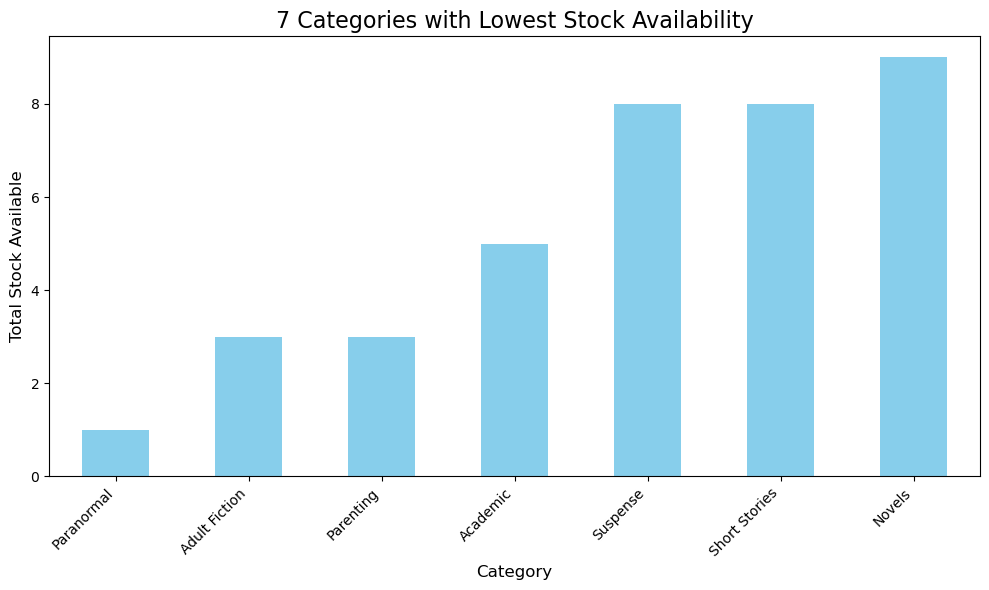

In [56]:
# Group the data by Category and sum the Availability
category_stock = df.groupby('Category')['Availability'].sum()

# Sort the data by total stock available in ascending order
category_stock = category_stock.sort_values()

# Select the 7 categories with the lowest total stock available
top_7_least_stock = category_stock.head(7)

# Plotting the bar graph
plt.figure(figsize=(10, 6))
top_7_least_stock.plot(kind='bar', color='skyblue')

# Adding title and labels
plt.title('7 Categories with Lowest Stock Availability', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Total Stock Available', fontsize=12)

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### หมวดหมู่ส่งผลต่อการเพิ่มยอดขายของบริษัท โดยมีแนวโน้มว่าหมวดหมู่ที่มีสต็อกน้อยจะแสดงถึงความนิยมในการเลือกซื้อหนังสือของลูกค้า ดังนั้นบริษัทควรพิจารณาเพิ่มสต็อกหนังสือในหมวดหมู่ที่ได้รับความนิยมสูงสุดจาก 7 หมวดหมู่ที่แสดงในกราฟ ได้แก่ Paranormal, Adult Fiction, Parenting, Academic, Short Stories, Suspense และ Novels เพื่อให้สามารถตอบสนองความต้องการของลูกค้าได้อย่างเหมาะสมและเพิ่มยอดขายได้

C:\Users\Dell\AppData\Local\Temp\ipykernel_20796\1796396811.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stock_by_price_bin = df.groupby('Price_Bin')['Availability'].mean()


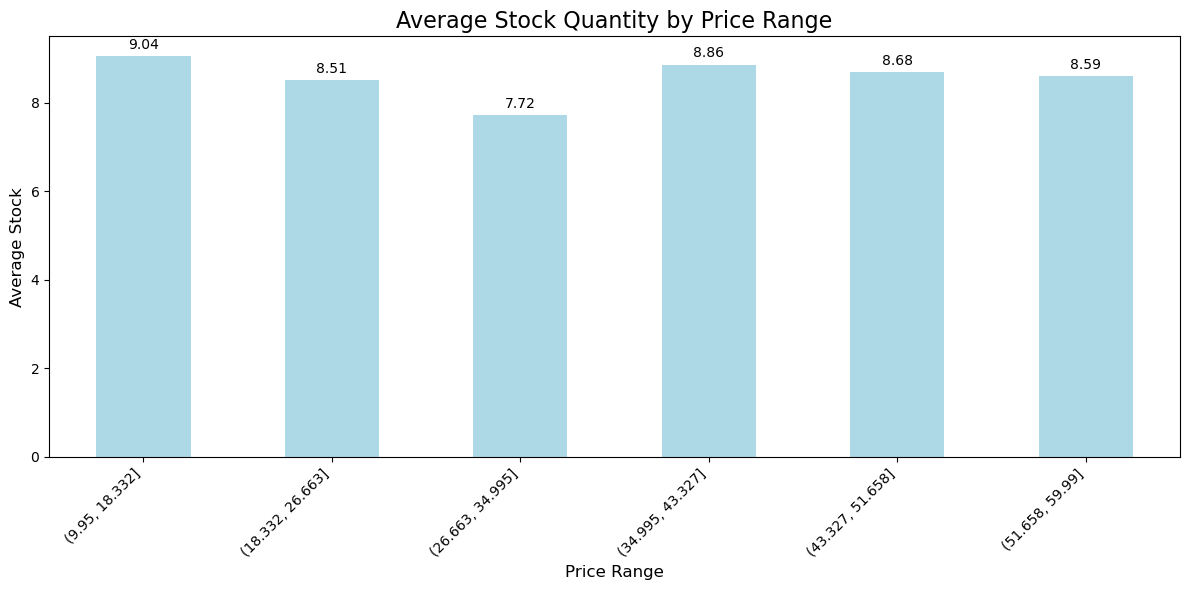

In [57]:
# Define the price bins (e.g., 5 equal intervals)
price_bins = pd.cut(df['Price'], bins=6)

# Create a DataFrame with the price bins
df['Price_Bin'] = price_bins

# Group by the price bins and calculate the mean of the stock
stock_by_price_bin = df.groupby('Price_Bin')['Availability'].mean()

# Plotting the bar graph
plt.figure(figsize=(12, 6))
ax = stock_by_price_bin.plot(kind='bar', color='lightblue')

# Adding title and labels
plt.title('Average Stock Quantity by Price Range', fontsize=16)
plt.xlabel('Price Range', fontsize=12)
plt.ylabel('Average Stock', fontsize=12)

# Adding labels on the bars
for i in ax.patches:
    height = i.get_height()
    ax.text(i.get_x() + i.get_width() / 2, height + 0.1, f'{height:.2f}', ha='center', va='bottom')

# Show the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### ราคาส่งผลต่อการเลือกซื้อหนังสือของลูกค้าได้หลากหลาย โดยพบว่าหนังสือในช่วงราคาต่าง ๆ มีสต็อกเฉลี่ยค่อนข้างใกล้เคียงกัน ซึ่งแสดงว่าปัจจัยเรื่องราคาไม่ได้ส่งผลต่อการตัดสินใจซื้อหนังสือมากนัก ดังนั้นร้านควรพิจารณาสั่งซื้อหนังสือในทุกช่วงราคาตามความต้องการของลูกค้า โดยเฉพาะในช่วงราคาที่สต็อกน้อยที่สุดอย่าง  28.746 ถึง 34.995 เพื่อให้มีสินค้าพร้อมจำหน่าย

## รายชื่อสมาชิกกลุ่ม
 
|ลำดับ|ชื่อ|รหัสนิสิต|
|--------|-------------|------------------|
|1|รมณ์มณียา สาริกา|65109010210|
|2|ชาลิสา ผิวไผ่|65109010290|
|3|อาภากร นพชาติสถิตย์|65109010309|
|4|ภรตา สุวรรณมา|65109010345|